In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Load dataset

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(60000, 28, 28) (10000, 28, 28)
(60000,) (10000,)


### Plot images

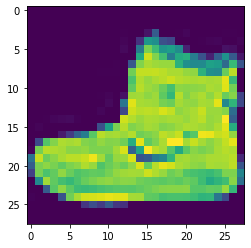

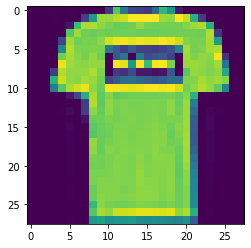

In [3]:
plt.imshow(x_train[0]); plt.show()
plt.imshow(x_train[1]); plt.show()

In [4]:
# add channel dimension
x_train = tf.expand_dims(x_train, -1)
x_test = tf.expand_dims(x_test, -1)
print(x_train.shape, x_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


In [5]:
x_train = tf.cast(x_train, tf.float32)/255.
x_test = tf.cast(x_test, tf.float32)/255.

### Tensorflow Input

In [6]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

### Fashion classification model

In [7]:
class fashion_cnn(keras.Model):
    
    def __init__(self):
        super(fashion_cnn, self).__init__()
        self.conv1 = keras.layers.Conv2D(32, 3, 1, activation='relu')
        self.conv2 = keras.layers.Conv2D(32, 3, 1, activation='relu')
        self.maxp = keras.layers.MaxPooling2D(2, 2)
        self.flatten = keras.layers.Flatten()
        self.d1 = keras.layers.Dense(64, activation='relu')
        self.d2 = keras.layers.Dense(10)
    
    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.maxp(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)

In [8]:
model = fashion_cnn()
loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = keras.optimizers.Adam()

### Metrics

In [9]:
train_loss = keras.metrics.Mean(name='train_loss')
train_accuracy = keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_loss = keras.metrics.Mean(name='test_loss')
test_accuracy = keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

### Train function

In [10]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return train_loss(loss), train_accuracy(labels, predictions)

In [11]:
@tf.function
def test_step(images, labels):
    predictions = model(images, training=False)
    loss = loss_object(labels, predictions)
    return test_loss(loss), test_accuracy(labels, predictions)

### Train

In [12]:
EPOCHS = 5

val_loss_monitor = []
patience = 1
for epoch in range(EPOCHS):
    
    train_loss.reset_states()
    test_loss.reset_states()
    train_accuracy.reset_states()
    test_accuracy.reset_states()
    
    for images, labels in train_ds:
        _, _ = train_step(images, labels)
    for images, labels in test_ds:
        _, _ = test_step(images, labels)
    
    template = 'Epoch {}, Loss {:.4f}, Acc:.2f}, Val_loss {:.4f}, Val_acc {:.2f}'
    print(template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result()*100,
                          test_loss.result(),
                          test_accuracy.result()*100))
    
    val_loss_monitor.append(test_loss.result())
    if len(val_loss_monitor) > 1:
        if val_loss_monitor[-1] > val_loss_monitor[-2]:
            print('Early Stopped!!!')
            break

Epoch 1, Loss 0.4349, ACC 84.40, Val_loss 0.3309, Val_acc 88.56
Epoch 2, Loss 0.2806, ACC 89.88, Val_loss 0.2747, Val_acc 89.99
Epoch 3, Loss 0.2318, ACC 91.50, Val_loss 0.2817, Val_acc 90.42
Early Stopped!!!


### Prediction

In [19]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
index_class = {k: v for k, v in zip(np.arange(10), class_names)}
index_class

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

In [26]:
def plot_prediction(tf_image):
    image = tf_image.numpy()
    prediction = model.predict(image[np.newaxis,...])
    y_hat = prediction.argmax()
    cat = index_class[y_hat]
    plt.imshow(image.squeeze())
    plt.title(cat)
    plt.show()

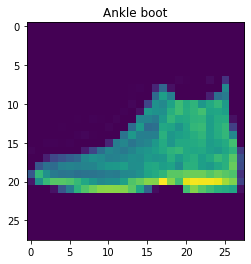

In [30]:
sample = x_test[0]
plot_prediction(sample)

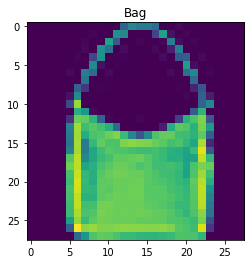

In [33]:
sample = x_test[34]
plot_prediction(sample)